In [39]:
import sys
sys.path.append('../') # path to bemcs
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import bemcs.kernels_stress_displacement as kernels

np.random.seed(43)

# Example 1: Fault at right angles
Consider a 3-element fault that meets only at right angles, and we impose slip on the node centers. In the following sections we consider 2 related cases. But first, let's look at the geometry of the fault.

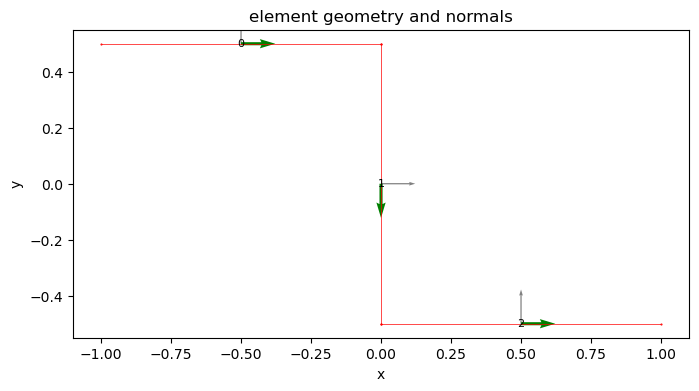

In [48]:
# use a non-uniform mesh
n_elements = 3
L_fault = 2. # fault length in x

# for a 3 element fault at right angles
x1 = np.array((-1.,0,0.))
x2 = np.array((0.,0.,1.))
y1 = np.array((0.5,0.5,-0.5))
y2 = np.array((0.5,-0.5,-0.5))

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)
# plot geometry of mesh
plt.figure(figsize=(15,4))
bemcs.plot_element_geometry(elements)


## Example 1a: Slip imposed in a constant $x,y$ direction

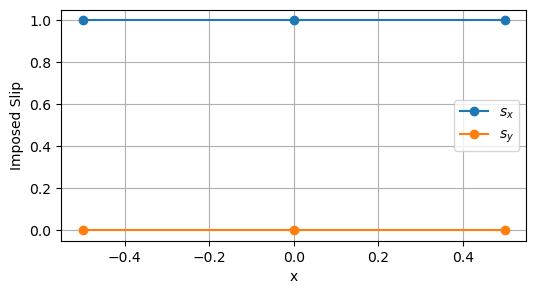

In [41]:
# slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array((1.,1.,1.))
slip_vector_y = np.array((0.,0.,0.))

# plot slip function
plt.figure(figsize=(6,3))
plt.plot((x1+x2)/2,slip_vector_x,'o-',label='$s_x$')
plt.plot((x1+x2)/2,slip_vector_y,'o-',label='$s_y$')
plt.xlabel('x')
plt.ylabel('Imposed Slip')
plt.grid()
plt.legend()
plt.show()

# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements)

matrix_system = np.zeros((len(elements)*6,len(elements)*6))

BCvector = np.zeros((len(elements)*6,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.
BCvector[-2:] = 0.

BCvector[2:-3:6] = slip_vector_x.reshape(-1,1)
BCvector[3:-2:6] = slip_vector_y.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0:2,:] = matrix_slip[0:2:]
matrix_system[-2:,:] = matrix_slip[-2:,:]

# patch center nodes
matrix_system[2:-3:6,:] = matrix_slip[2:-3:6,:]
matrix_system[3:-2:6,:] = matrix_slip[3:-2:6,:]

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6,:] = matrix_slip[4:-7:6,:] - matrix_slip[6:-5:6,:]# x component
matrix_system[5:-6:6,:] = matrix_slip[5:-6:6,:] - matrix_slip[7:-4:6,:]# y component
# smoothness
matrix_system[6:-5:6,:] = matrix_slipgradient[4:-7:6,:] - matrix_slipgradient[6:-5:6,:]# x component
matrix_system[7:-4:6,:] = matrix_slipgradient[5:-6:6,:] - matrix_slipgradient[7:-4:6,:]# y component 

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

### Compute displacement, stress kernels 

In [42]:
# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# compute displacements and stresses (we will plot it later)
ux_1 = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy_1 = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx_1 = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy_1 = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy_1 = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

## Example 1b: Slip imposed only along the shear component

In [43]:
# slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array((1.,0.,1.))
slip_vector_y = np.array((0.,-1.,0.))

# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements)

matrix_system = np.zeros((len(elements)*6,len(elements)*6))

BCvector = np.zeros((len(elements)*6,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.
BCvector[-2:] = 0.

BCvector[2:-3:6] = slip_vector_x.reshape(-1,1)
BCvector[3:-2:6] = slip_vector_y.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0:2,:] = matrix_slip[0:2:]
matrix_system[-2:,:] = matrix_slip[-2:,:]

# patch center nodes
matrix_system[2:-3:6,:] = matrix_slip[2:-3:6,:]
matrix_system[3:-2:6,:] = matrix_slip[3:-2:6,:]

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6,:] = matrix_slip[4:-7:6,:] - matrix_slip[6:-5:6,:]# x component
matrix_system[5:-6:6,:] = matrix_slip[5:-6:6,:] - matrix_slip[7:-4:6,:]# y component
# smoothness
matrix_system[6:-5:6,:] = matrix_slipgradient[4:-7:6,:] - matrix_slipgradient[6:-5:6,:]# x component
matrix_system[7:-4:6,:] = matrix_slipgradient[5:-6:6,:] - matrix_slipgradient[7:-4:6,:]# y component 

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

# compute displacement and stresses (we will plot it later)
ux_2 = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy_2 = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx_2 = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy_2 = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy_2 = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n


## Plot displacements and stresses for 1a and 1b

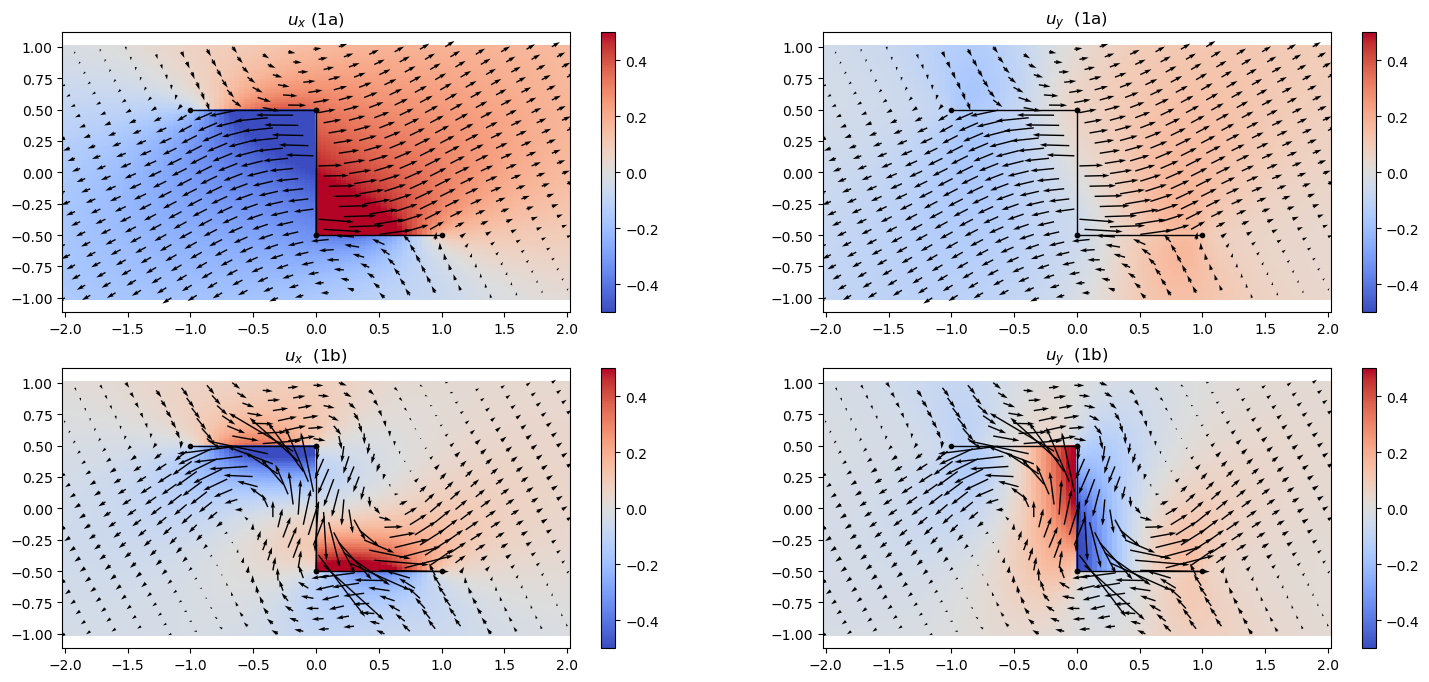

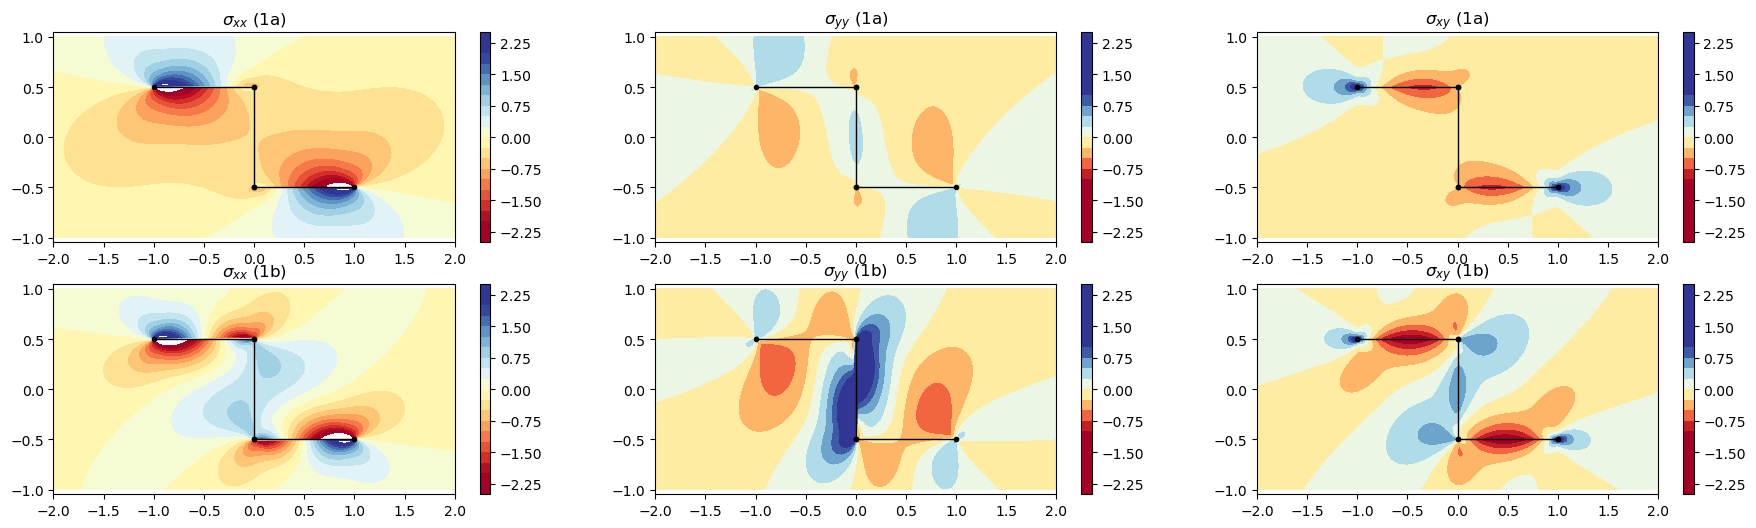

In [44]:
nskip_plot = 21 # plotting for vectors

# displacements
plt.figure(figsize=(18,8))
plt.subplot(2, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux_1.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux_1[0::nskip_plot],uy_1[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$ (1a)")

plt.subplot(2, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy_1.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux_1[0::nskip_plot],uy_1[0::nskip_plot])
plt.title("$u_y$  (1a)")
plt.axis("equal")

plt.subplot(2, 2, 3)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux_2.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux_2[0::nskip_plot],uy_2[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$  (1b)")

plt.subplot(2, 2, 4)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy_2.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux_2[0::nskip_plot],uy_2[0::nskip_plot])
plt.title("$u_y$  (1b)")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 6))
plt.subplot(2, 3, 1)
toplot = sxx_1
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$ (1a)")

plt.subplot(2, 3, 2)
toplot = syy_1
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$ (1a)")

plt.subplot(2, 3, 3)
toplot = sxy_1
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$ (1a)")

plt.subplot(2, 3, 4)
toplot = sxx_2
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$ (1b)")

plt.subplot(2, 3, 5)
toplot = syy_2
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$ (1b)")

plt.subplot(2, 3, 6)
toplot = sxy_2
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$ (1b)")
plt.show()

# Example 2: Sinusoidal fault

For a sinusoidal fault in an $x,y$ coordinate system, $y = A\sin\left(\frac{2n\pi}{L}\right)$ where $A$ is the amplitude, $n$ is the number of cycles of the sinusoid and $L$ is the fault length in the $x$ dimension. 

In this example we force the slip vector to have purely shear sense slip at the element centers while at the edge nodes continuity and smoothness conditions take over. The resulting slip distribution is rather intriguing! Tensile slip remains 0 at patch centers, as we prescribed, but it is discontinuous and non-zero at overlapping nodes while the slip vector in an $x,y$ coordinate system remains continuous and smooth.

In [45]:
# flag for slip to be purely shear
slip_purely_shear = True


If you want to test the other option i.e., impose slip in a uniform $x,y$ direction, simply set the variable `slip_purely_shear = False`

Forcing slip vector at patch centers to be purely shear


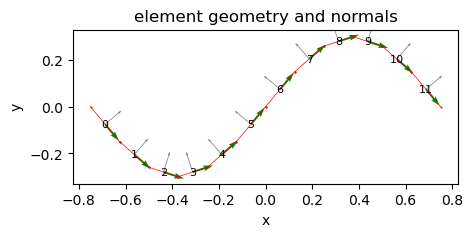

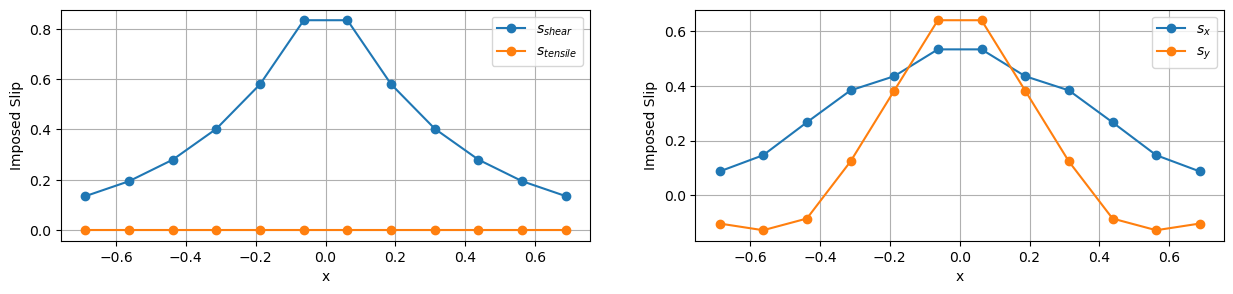

In [46]:
# use a non-uniform mesh
n_elements = 12
L_fault = 1.5 # fault length in x

# specify amplitude and number of wavelengths for sinusoidal fault geometry
y_amplitude,lambda_cycles = 0.3,1.

# sinusoidal y-positions for fault elements
sorted_xlocs = np.linspace(-L_fault/2 + L_fault/n_elements,L_fault/2-L_fault/n_elements,n_elements-1)

# rough fault
x1 = np.concatenate((np.array([-L_fault/2.]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs,np.array([L_fault/2.])))
y1 = y_amplitude*np.sin(lambda_cycles*2*np.pi*x1/L_fault)
y2 = y_amplitude*np.sin(lambda_cycles*2*np.pi*x2/L_fault)

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_values = np.exp(-np.abs(np.linspace(-1,1,n_elements))/2/(0.5**2))
slip_vector_x = np.zeros_like(slip_values)
slip_vector_y = np.zeros_like(slip_values)
slip_vector_s = np.zeros_like(slip_values)
slip_vector_n = np.zeros_like(slip_values)

# force slip vector to be purely shear (s_n = 0)
if slip_purely_shear==True:
    slip_vector_s = slip_values
    slip_vector_n = np.zeros_like(slip_vector_s)
    slip_vector = np.vstack((slip_vector_s,slip_vector_n)).T
    print("Forcing slip vector at patch centers to be purely shear")
    for i in range(len(elements)):
        slip_vector_x[i],slip_vector_y[i] = slip_vector[i,:]@elements[i]["inverse_rotation_matrix"]
else:
    slip_vector_x = slip_values
    slip_vector_y = np.zeros_like(slip_vector_x)
    slip_vector = np.vstack((slip_vector_x,slip_vector_y)).T
    for i in range(len(elements)):
        slip_vector_s[i],slip_vector_n[i] = slip_vector[i,:]@elements[i]["rotation_matrix"]

# plot geometry of mesh
plt.figure(figsize=(15,2))
bemcs.plot_element_geometry(elements)

# plot slip function
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot((x1+x2)/2,slip_vector_s,'o-',label='$s_{shear}$')
plt.plot((x1+x2)/2,slip_vector_n,'o-',label='$s_{tensile}$')
plt.xlabel('x')
plt.ylabel('Imposed Slip')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot((x1+x2)/2,slip_vector_x,'o-',label='$s_x$')
plt.plot((x1+x2)/2,slip_vector_y,'o-',label='$s_y$')
plt.xlabel('x')
plt.ylabel('Imposed Slip')
plt.grid()
plt.legend()
plt.show()

# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements)

matrix_system = np.zeros((len(elements)*6,len(elements)*6))

BCvector = np.zeros((len(elements)*6,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.
BCvector[-2:] = 0.

BCvector[2:-3:6] = slip_vector_x.reshape(-1,1)
BCvector[3:-2:6] = slip_vector_y.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
# matrix_system[0:2,:] = matrix_slipgradient[0:2:]
# matrix_system[-2:,:] = matrix_slipgradient[-2:,:]
matrix_system[0:2,:] = matrix_slip[0:2:]
matrix_system[-2:,:] = matrix_slip[-2:,:]

# patch center nodes
matrix_system[2:-3:6,:] = matrix_slip[2:-3:6,:]
matrix_system[3:-2:6,:] = matrix_slip[3:-2:6,:]

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6,:] = matrix_slip[4:-7:6,:] - matrix_slip[6:-5:6,:]# x component
matrix_system[5:-6:6,:] = matrix_slip[5:-6:6,:] - matrix_slip[7:-4:6,:]# y component
# smoothness
matrix_system[6:-5:6,:] = matrix_slipgradient[4:-7:6,:] - matrix_slipgradient[6:-5:6,:]# x component
matrix_system[7:-4:6,:] = matrix_slipgradient[5:-6:6,:] - matrix_slipgradient[7:-4:6,:]# y component 

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

### Plot displacement, stresses and slip

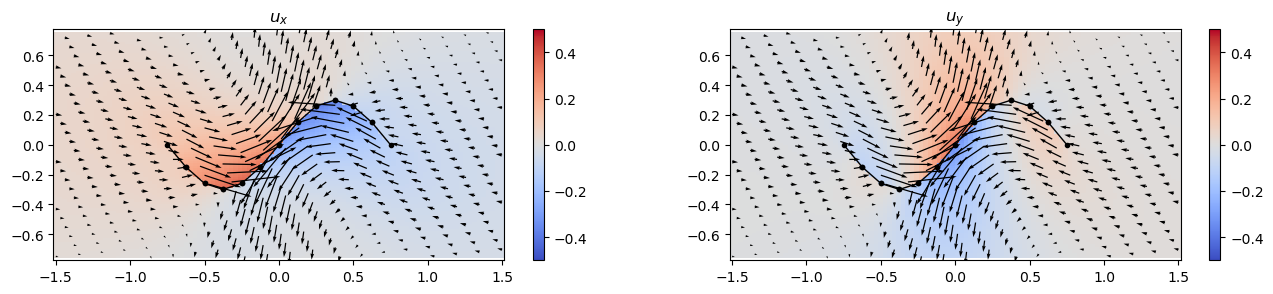

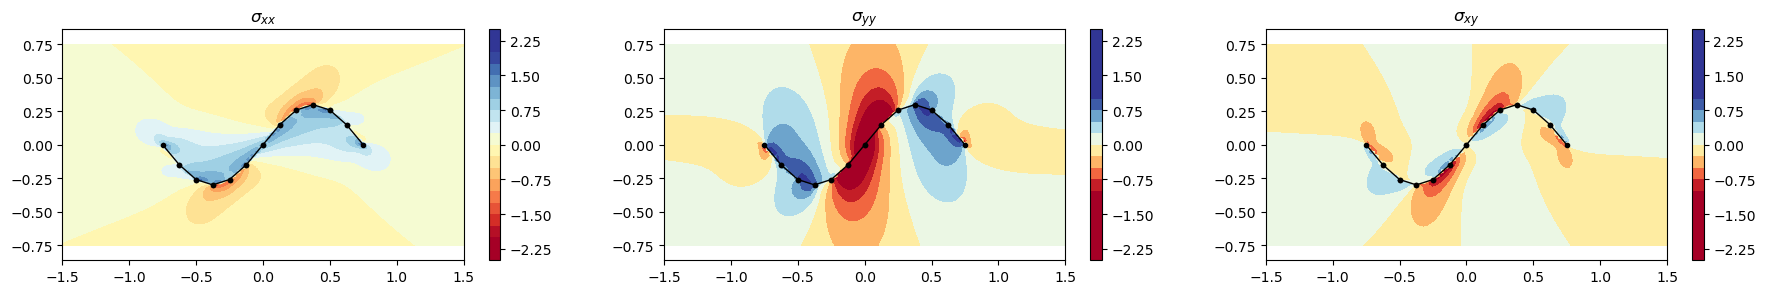

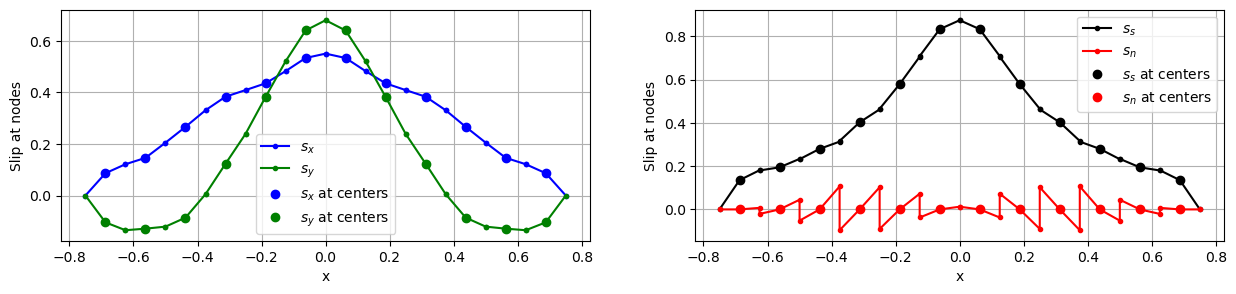

In [47]:
# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 1.5
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)
# plot displacements and stresses
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n

nskip_plot = 21 # plotting for vectors

# displacements
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n
plt.contourf(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),levels=np.linspace(-2.5, 2.5, 21),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()

# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x,slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3*len(elements),1))
slip_nodes_n = np.zeros((3*len(elements),1))

for i in range(len(elements)):
    dummy = slip_vector[3*i:3*(i+1),:]@elements[i]["rotation_matrix"]
    slip_nodes_s[3*i:3*(i+1),0] = dummy[:,0]
    slip_nodes_n[3*i:3*(i+1),0] = dummy[:,1]

xnodes = np.zeros((3*len(elements),1))
xnodes[0::3,0] = x1
xnodes[2::3,0] = x2
xnodes[1::3,0] = 0.5*(x1 + x2)

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(xnodes,slip_nodes_x,'b.-',label='$s_x$')
plt.plot(xnodes,slip_nodes_y,'g.-',label='$s_y$')
plt.plot(xnodes[1:-1:3,0],slip_nodes_x[1:-1:3,0],'bo',label='$s_x$ at centers')
plt.plot(xnodes[1:-1:3,0],slip_nodes_y[1:-1:3,0],'go',label='$s_y$ at centers')
plt.xlabel("x")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(xnodes,slip_nodes_s,'k.-',label='$s_s$')
plt.plot(xnodes,slip_nodes_n,'r.-',label='$s_n$')
plt.plot(xnodes[1:-1:3,0],slip_nodes_s[1:-1:3,0],'ko',label='$s_s$ at centers')
plt.plot(xnodes[1:-1:3,0],slip_nodes_n[1:-1:3,0],'ro',label='$s_n$ at centers')
plt.xlabel("x")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()